#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [ ]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [ ]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

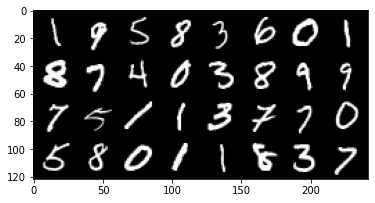

        1         9         5         8


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [ ]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   100] loss: 1.351
[1,   200] loss: 0.499
[1,   300] loss: 0.403
[1,   400] loss: 0.364
[1,   500] loss: 0.342
[1,   600] loss: 0.330
[1,   700] loss: 0.315
[1,   800] loss: 0.291
[1,   900] loss: 0.308
[1,  1000] loss: 0.260
[1,  1100] loss: 0.266
[1,  1200] loss: 0.237
[1,  1300] loss: 0.248
[1,  1400] loss: 0.236
[1,  1500] loss: 0.218
[1,  1600] loss: 0.187
[1,  1700] loss: 0.206
[1,  1800] loss: 0.187


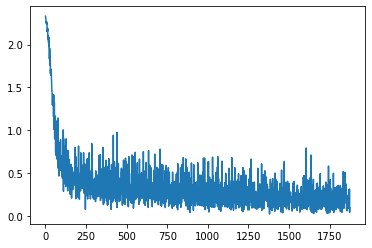

In [ ]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


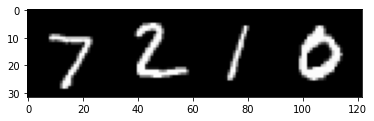

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [ ]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [ ]:
print("Current accuracy: %f" % accuracy(net, data['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current accuracy: 0.950350


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.9585 0.9468 0.896


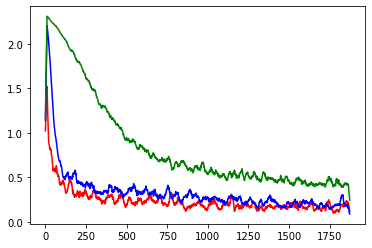

In [ ]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

I tried four diffferent values of momentum - 7, 0.7, 0.07, and 0.007. As we can see, each value is of a different magnitude. Momentum=7 was by far the worst performer of the group, showing only a 9.8% final test accuracy. The difference in convergance between momentum=7 and other values was so high, that it could not be plotted properly on the same scale (hence, I have not included the convergance for momentum=7 in the plot below). Clearly, such a high value for momentum negatively affected our model's performance. 

For the other values, despite the big difference between them, the models showed similar accuracies and convergance (shown in plot below code). That said, I did see a pattern where higher momentum values (excluding momentum = 7) reported better final accuracies, albeit by a small margin. Momentum of 0.7 had a final test accuracy of 96.1%, momentum of 0.09 had a final test accuracy of 95.2%, and momentum of 0.009 had a final test accuracy of 94.88%. 

Regarding convergance, while the momentums of 0.7, 0.07, and 0.007 all ended up around the same loss (close to 0), we see that the momentum=0.7 (the red line) converged the fastest, while momentum=0.07 (blue line) and momentum=0.007(green line) showed similar convergance trends. Also from the plot, we can see that had the training loop run less number of times, we would have seen a larger difference between the three values, with 0.7 being the best performer. 

Thus, from the above data, we can conclude that peak performance is acheived around momentum=0.7. Momentum of other magnitudes are likely to result in a worse performing model. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.098 0.961 0.952 0.9488


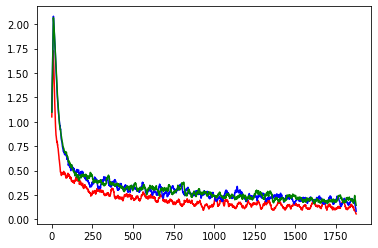

In [ ]:
fixed_lr = 0.1 # Chosen based on result of previous experiment

net_very_high_moment = SimpleNet();
losses_very_high_moment = train(net_very_high_moment, data['train'], lr=fixed_lr, momentum=7, verbose=0)
acc_very_high_moment = accuracy(net_very_high_moment, data['test'])
# plt.plot(smooth(losses_very_high_moment,20), 'y-')

net_high_moment = SimpleNet();
losses_high_moment = train(net_high_moment, data['train'], lr=fixed_lr, momentum=0.7, verbose=0)
acc_high_moment = accuracy(net_high_moment, data['test'])
plt.plot(smooth(losses_high_moment,20), 'r-')


net_mid_moment = SimpleNet()
losses_mid_moment = train(net_mid_moment, data['train'], lr=fixed_lr, momentum=0.07, verbose=0)
acc_mid_moment = accuracy(net_mid_moment, data['test'])
plt.plot(smooth(losses_mid_moment,20), 'b-')


net_low_moment = SimpleNet()
losses_low_moment = train(net_low_moment, data['train'], lr=fixed_lr, momentum=0.007, verbose=0)
acc_low_moment = accuracy(net_low_moment, data['test'])
plt.plot(smooth(losses_low_moment,20), 'g-')

print(acc_very_high_moment, acc_high_moment, acc_mid_moment, acc_low_moment)

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

A model is overfit when it reports high accuracies for training data, however does not generalize for test data, resulting in poor test accuracy scores. On the other hand, a model is underfit when it does not generalise to the best of its ability, resulting in worse training and test accuracy scores than expected.

Our current model has a train accuracy score of 96.76% and a test accuracy score of 96.4%. Since test accuracy is almost the same as training accuracy, we can say the model is not overfit

The best performing neural net for the MNIST dataset has an accuracy of 99.87%. Cleary, there is still room for our model to "learn" more about the data and generalize better. Thus, our model is underfit to the data. 

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

For this question, I tried 4 different values for decay - 0.0 (default value), 0.1, 0.01, and 0.001. Clearly, all 4 values are of different magnitudes.

From the plot below, we can see that lower values of decay converge faster. In fact, decay=0.1 (red line), does not even converge as much as the rest of the values, all of which reach very close to 0 loss. Furthermore, we see that between decay=0.01 (blue line), decay=0.001 (green line), and decay=0.0 (yellow line), decay=0.001 and decay=0.0 converge faster and finish at a lower loss than decay=0.01. Clearly, smaller decay values performed better than larger values.

The values of final test accuracy also match up with our above observation about convergance. The highest test accuracy is reported by decay=0.0 at 96.4%, followed by decay=0.001 at 96.05%, followed by decay=0.01 at 91.41%. The largest value of decay, 0.1, had the worst final test accuracy at 75.76%. Just lie with convergance, smaller decay values performed better than larger decay values.

These observations match up with what I would expect. Decay specifies the value we multiply our learning rate with at each weight update. A smaller decay means that the learning rate stays about the same after each iteration, whereas a larger decay will result in the learning rate decreasing significantly after every iteration. A smaller learning rate will prevent our model from "learning" the data, causing it to make smaller and smaller improvements in accuracy after each iteration. We see this in the plot below as well, where larger values of decay "flatten" out earlier than smaller values of decay which maintain their steepnes for longer. Thus, smaller decay values result in better model performance than larger decay values. 

In [ ]:
best_lr = 0.1 # Best performing lr from the learning rate experiment
best_momentum = 0.7 #Best perfoming momentum from the momentum experiment

default_decay_model = SimpleNet()
losses_default_decay = train(default_decay_model, data['train'], lr=best_lr, momentum=best_momentum, verbose=0)
acc_default_decay_train = accuracy(default_decay_model, data['train'])
acc_default_decay_test = accuracy(default_decay_model, data['test'])

print("Train accuracy: ", acc_default_decay_train, ", Test accuracy: ", acc_default_decay_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy:  0.9676 , Test accuracy:  0.964


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.964 0.7576 0.9141 0.9605


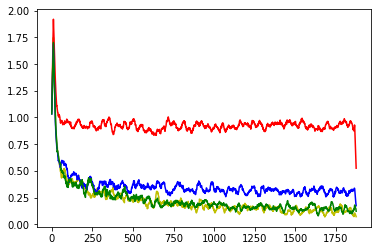

In [ ]:
plt.plot(smooth(losses_default_decay,20), 'y-') # Plot the default decay performance


high_decay_model = SimpleNet()
losses_high_decay = train(high_decay_model, data['train'], lr=best_lr, momentum=best_momentum, verbose=0, decay=0.1)
acc_high_decay_test = accuracy(high_decay_model, data['test'])
plt.plot(smooth(losses_high_decay,20), 'r-')

med_decay_model = SimpleNet()
losses_med_decay = train(med_decay_model, data['train'], lr=best_lr, momentum=best_momentum, verbose=0, decay=0.01)
acc_med_decay_test = accuracy(med_decay_model, data['test'])
plt.plot(smooth(losses_med_decay,20), 'b-')

low_decay_model = SimpleNet()
losses_low_decay = train(low_decay_model, data['train'], lr=best_lr, momentum=best_momentum, verbose=0, decay=0.001)
acc_low_decay_test = accuracy(low_decay_model, data['test'])
plt.plot(smooth(losses_low_decay,20), 'g-')

print(acc_default_decay_test, acc_high_decay_test, acc_med_decay_test, acc_low_decay_test)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

My final model archeteciture is a neural network with one hidden layer. The first layer takes an input of 28*28 inputs, and returns 1024 outputs. The hidden layer takes 1024 inputs and gives 512 outputs. Finally, the third layer takes 512 inputs and gives 10 outputs. 

I chose an architecture with one hiddden layer because of the Universal Approximation Theorem, which states that a 1-layer neural network can model any continuous function f, if we use a nonconstant, bounded, monotonically increasing function as our activation function. From the UAT, we see that adding more layers is not guaranteed to result in a better model. Thus, I chose to work with just 1 hidden layer and focus on hyperparameter tuning. 

For the number of neurons at each layer, I just experimented with different numbers till I found the best ones. Currently, the number of neurons at each layer are as follows:

  - first layer: (28*28 * 1024) = 802816
  - second layer: (1024 * 512) = 524288
  - third layer: (512 * 10) = 5120
  - total:  1332224

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

I experimented with learning rate, decay, momentum, number of neurons in a layer, and activation functions. 

For learning rate and decay, I found the above suggested approach to be the best. Controlling learning rate manually, as suggested above, resulted in a training accuracy of >99% and testing accuracy of 98.54%. This is in stark contrast to my earlier approach of using decay to lower learning rate in later epochs, which yeilded a training accuracy of 95.37% and testing accuracy of 94.792%. 

For momentum, I found that momentum=0.7 always gave the best results, with other values fixed. This is in accordance with our results from the momentum experiment where we found momentum=0.7 to be the best value as well. 

For number of neurons in a layer, I experimented with different values and chose the ones that gave the highest training and test accuracy, while staying under the limit of 2,000,000 connections. Notably, all other values for number of neurons performed significantly worse than the current setup, with training accuracy dropping as low as 9% and only reaching as high as 90%. For comparison, the current setup has a 99% training accuracy. 

Finally, for activation functions, I once again experimented with functions from the given list of Activation functions. Initially, I tried running the model with sigmoid functions but did not recieve great results. Using tan functions also gave similar results to sigmoid. Switching to RELU functions significantly improved results. Furthermore, of all the RELU functions, LeakyRELU proved to be the best.

For some of the hyperparameter combinations, my model was reporting training accuracies ~75% and testing accuracies ~65%. In those cases, my model was definitely overfitting. 

For the current hyperparamter values, the training accuracy is 99.936% and testing accuracy is 98.54%. While high, these benchmarks are still not as good as the best performing MNIST dataset which has a 99.87% testing accuracy. This implies that there is still room for my model to "learn" more about the data, and generalise better, which would help it score higher in both traning and testing accuracy. From this, we can conclude that my model is slightly underfit. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Acc:  0.9993666666666666 , Test Acc:  0.9854


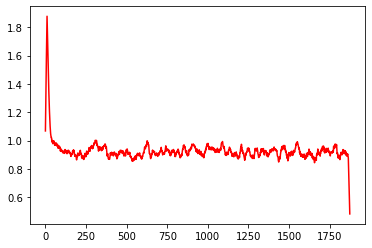

In [ ]:
best_momentum = 0.7 

import torch.nn as nn
import torch.nn.functional as F

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

experi_model = ExperiNet()
experiment_losses = train(experi_model, data['train'], epochs=5, lr=.1,momentum=best_momentum, verbose=0)
experiment_losses.append(train(experi_model, data['train'], epochs=3, lr=.01,momentum=best_momentum, verbose=0))
experiment_losses.append(train(experi_model, data['train'], epochs=2, lr=.001,momentum=best_momentum, verbose=0))
experiment_test_acc = accuracy(experi_model, data['test'])
experiment_train_acc = accuracy(experi_model, data['train'])
plt.plot(smooth(losses_high_decay,20), 'r-')
print("Train Acc: ", experiment_train_acc, ", Test Acc: ", experiment_test_acc)

##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.